In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dat_dir = '../data/'
sub_dir = '../submit/'

## Part 1: Data Loading and Pre-processing

#### 1.1 Load the data

In [3]:
# Firstly we have a glance at the dataset
data = pd.read_csv(dat_dir + "data_train.csv")
data['row'], data['column'] = data['Id'].str.split('_', 1).str
data.head()

Id  Prediction  row column
0  r44_c1           4  r44     c1
1  r61_c1           3  r61     c1
2  r67_c1           4  r67     c1
3  r72_c1           3  r72     c1
4  r86_c1           5  r86     c1

In [4]:
data['Prediction'].median()

4.0

In [5]:
data['Prediction'].mean()

3.8572805008190647

In [6]:
data['row'] = data['row'].apply(lambda x: int(x.replace("r","")))
data['column'] = data['column'].apply(lambda x: int(x.replace("c","")))

In [7]:
data.max()

Id            r9_c999
Prediction          5
row             10000
column           1000
dtype: object

E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


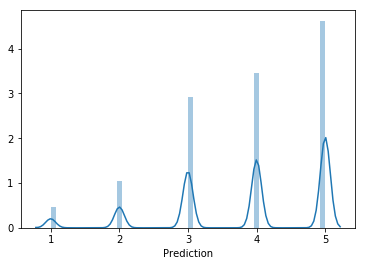

In [27]:
sns.distplot(data['Prediction'])

In [22]:
# We have 10,000 rows (users) and 1,000 columns (movies). However, we will take movies as rows and users as columns to build the ratings matrix for convenient 
from data_process import load_data

ratings = load_data(dat_dir + "data_train.csv")
print(np.shape(ratings))

number of items: 1000, number of users: 10000
(1000, 10000)


In [26]:
# Plot the number of ratings per movie and user
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))
# Since only a few users rated a small amount of movies and the same as the movies, we take all the users and movies into account.

min # of items per user = 3, min # of users per item = 8.


#### 1.2 Split the data into a training and test set

In [5]:
from data_process import split_data

valid_ratings, train, test = split_data(ratings, p_test=0.1)

the shape of original ratings. (# of row, # of col): (1000, 10000)
the shape of valid ratings. (# of row, # of col): (1000, 10000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1068598
Total number of nonzero elements in test data:108354


## Part 2: Learn the Matrix Factorization using SGD

#### 2.1: Finding parameters for SGD by grid search

In [6]:
from SGD_helpers import init_MF, matrix_factorization_SGD

We need to find the values of the step size $\gamma$ first for a fixed value of the 3 other parameters and then compute a grid search to find the best parameters for the regularizers $\lambda_{user}$, $\lambda_{item}$ (both between 0 and 1) and the number of features $K$

After many computations (not only on logspace) for same parameters for K and the 2 lambdas, we found that $\gamma = 0.025$ is the best

As showed in the following grid, we see that the minimal loss is obtained for parameters $\lambda_{user} = 0.1$ and $\lambda_{item} = 0.01$ and number of features $K = 20$ :

In [6]:
# Finding other parameters

#### 2.1: Running SGD with the best parameters

In [ ]:
from SGD_helpers import  init_MF, matrix_factorization_SGD
best_gamma = 0.025
best_lambda_u = 0.1
best_lambda_i = 0.01
K = 20
num_epochs = 50

user_init, item_init = init_MF(ratings, K)
item_feats_SGD, user_feats_SGD, rmse = matrix_factorization_SGD(ratings, test, best_gamma, K, best_lambda_u, best_lambda_i, num_epochs,
                                                                    user_init, item_init)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0386530101955693.
iter: 5, RMSE on training set: 0.9510841562104476.
iter: 10, RMSE on training set: 0.9111545179069976.
iter: 15, RMSE on training set: 0.8976946302047759.
iter: 20, RMSE on training set: 0.8935320051833767.
iter: 25, RMSE on training set: 0.8921384059425551.
iter: 30, RMSE on training set: 0.8916257646799413.
iter: 35, RMSE on training set: 0.8914260926528095.


In [16]:
# save features
tempt_dir = '../tempt/'

np.save(tempt_dir + 'item_feats_SGD.npy', item_feats_SGD)
np.save(tempt_dir + 'user_feats_SGD.npy', user_feats_SGD)

# load features
# item_feats_SGD = np.load(tempt_dir + 'item_feats_SGD.npy')
# user_feats_SGD = np.load(tempt_dir + 'user_feats_SGD.npy')

In [22]:
from data_process import create_submission

create_submission(predictions)

Shape of predictions (user x items): (1000, 10000)


## Part 3: Build the Biased Model of Matrix Factorization

In [26]:
from MF_helpers import get_bias_train, get_bias_test

Instead of having $p_{u, i} = \mathbf{w}_i\mathbf{z^{T}}_u$ we would add bias on the user and item by having the following:
$$p_{u, i} = \mu + b_{u} + b_{i} + \mathbf{w}_i\mathbf{z^{T}}_u$$

where $\mu$ is the average of all ratings, $b_{u}$ and $b_{i}$ are the observed deviations of user u and item i respectively from the average (the biases).

Thus we now want to find the best $\mathbf{W}$ and $\mathbf{Z}$ that minimizes the loss:

$$min_{W,Z} \sum_{(u, i) \in \Omega} (r_{u,i} - \mu - b_{u} - b_{i} - \mathbf{W_{u}} \mathbf{Z^{T}_{i}}) + \lambda_{item} (||W||_{F}^{2} + b_{i}^{2}) + \lambda_{user} (||Z||_{F}^{2} + b_{u}^{2}) $$

And we need to compute the gradient of this loss. It is the same as before except we can convert our rating matrix to a biased rating matrix with ratings $r'_{u, i} = r_{u, i} - \mu - b_{u} - b_{i}$ and compute our SGD on this biased matrix

In [27]:
bias_train, total_bias, bias_u_train, bias_i_train = get_bias_train(train) #ratings for final submissions
bias_test = get_bias_test(test, total_bias, bias_u_train, bias_i_train)

Compute grid search with best parameters (here just with K = 20 features):

In [115]:
# Grid Search:
grid = np.zeros((4, 4)) ### np.zeros((4, 4, 4))
gamma = 0.025 # best gamma we found above
num_epochs = 5
lambdas_user = np.logspace(-3,0,4)[::-1] #From max to min
lambdas_item = np.logspace(-3,0,4)[::-1]
K = 20

min_loss = 100000
best_user_feats = []
best_item_feats = []

### Warm start: directly start computation from previously computed item_features and user_features and not random initialization
user_init, item_init = init_MF(bias_train, K)
for x,lambda_u in enumerate(lambdas_user):
    for y,lambda_i in enumerate(lambdas_item):
        print("K = {}, lambda_u = {}, lambda_i = {}".format(int(K), lambda_u, lambda_i))
        item_feats, user_feats, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_i,
                                                                 lambda_u, num_epochs, user_init, item_init)
        ### For warm start, we keep the user_features and item_features that gave us the minimal rmse previously computed
        if rmse < min_loss:
            print("New best")
            min_loss = rmse
            user_init = user_feats
            item_init = item_feats
            best_user_feats = np.copy(user_feats)
            best_item_feats = np.copy(item_feats)
        grid[x, y] = rmse

K = 20, lambda_u = 1.0, lambda_i = 1.0
learn the matrix factorization using SGD...


KeyboardInterrupt: 

Compute SGD with the best parameters:

In [28]:
# define parameters
gamma = 0.025
K = 50
lambda_user = 0.1 
lambda_item = 0.01
num_epochs = 50
user_init, item_init = init_MF(bias_train, K)

item_featuresSGD, user_featuresSGD, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_user, lambda_item, num_epochs, user_init, item_init)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0148365823565952.
iter: 5, RMSE on training set: 0.880109842486806.
iter: 10, RMSE on training set: 0.8252870439456371.
iter: 15, RMSE on training set: 0.8065028849906606.
iter: 20, RMSE on training set: 0.7996947945129235.
iter: 25, RMSE on training set: 0.7970885996782676.
iter: 30, RMSE on training set: 0.7960619899593706.
iter: 35, RMSE on training set: 0.7956524401101966.
iter: 40, RMSE on training set: 0.795488334459468.
iter: 45, RMSE on training set: 0.7954224582089823.
iter: 49, RMSE on training set: 0.7953995516544337.
RMSE on test data: 1.029180515629877.


In [19]:
from MF_helpers import predict_no_bias
predictions = predict_no_bias(item_featuresSGD, user_featuresSGD)

NameError: name 'item_featuresSGD' is not defined

In [30]:
tempt_dir = '../data/'
np.save(tempt_dir + 'item_feature_bias.npy', item_featuresSGD)
np.save(tempt_dir + 'user_feature_bias.npy', user_featuresSGD)

In [16]:
import pickle
tempt_dir = './'
with open(tempt_dir + 'user_features_bias.pk','rb') as f:
    user_featuresSGD = pickle.load(f)
    
with open(tempt_dir + 'item_features_bias.pk','rb') as f:
    item_featuresSGD = pickle.load(f)

Compute the predictions:

In [32]:
from MF_helpers import predict_with_bias, predict_no_bias

# Compute predictions matrix from the biases, item and user features computed with SGD
predictions = predict_with_bias(item_featuresSGD, user_featuresSGD, total_bias, bias_u_train, bias_i_train)
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))

Shape of predictions (user x items): (1000, 10000)


In [33]:
### Checking if results appear the same in the final excel file
first_user, first_item = sample_ids[0][0],sample_ids[0][1]
print(first_item, first_user)
print(predictions[first_user - 1, first_item - 1])

1 37
4.307041082580035


## Part 4: Submission

In [ ]:
from data_process import create_submission
create_submission(predictions)